In [ ]:
# @title Libraries
%%capture
%pip install TerraYolo

import os
import shutil
import random
import gdown
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from TerraYolo.TerraYolo import TerraYoloV5
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import shutil

In [ ]:
source = '/content/drive/MyDrive/DIPLOMA/peoplecount.zip'

destination = '/content'

shutil.copy(source, destination)

'/content/peoplecount.zip'

In [ ]:
# @title Загрузка...
#archive = /content/drive/MyDrive/DIPLOMA/peoplecount.zip'


In [ ]:
# Задание имени рабочего каталога
DATASET_DIR = '/content/dataset'


In [ ]:
# Создание рабочего каталога
os.makedirs(DATASET_DIR, exist_ok=True)
shutil.rmtree('sample_data')


In [ ]:
# Распаковка архива
shutil.unpack_archive('/content/peoplecount.zip', DATASET_DIR)
print("Архив успешно разархивирован")

Архив успешно разархивирован


# *Формирование датасета*

In [ ]:
# Задание пути к yaml-файлу
data_path = os.path.join('/content/dataset/data.yaml') #сохраним путь к файлу в отдельную переменную
with open(data_path, 'r') as f: print(f.read())

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['man', 'woman']

roboflow:
  workspace: iron-man-slzhy
  project: diploma_final
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/iron-man-slzhy/diploma_final/dataset/2


In [ ]:
img_list = sorted(os.listdir('/content/dataset/train/images'))
lable_list = sorted(os.listdir('/content/dataset/train/labels'))

print(img_list[0])
print(lable_list[0])

100_jpg.rf.17191796325b6c8f33a8e8f2d2394e82.jpg
100_jpg.rf.17191796325b6c8f33a8e8f2d2394e82.txt


In [ ]:
!cat /content/dataset/train/labels/100_jpg.rf.17191796325b6c8f33a8e8f2d2394e82.txt

1 0.5078125 0.6777777777777778 0.0953125 0.3527777777777778
1 0.634375 0.49444444444444446 0.0796875 0.4638888888888889
0 0.3484375 0.5083333333333333 0.09375 0.4666666666666667
0 0.1890625 0.5111111111111111 0.265625 0.8833333333333333
1 0.471875 0.5111111111111111 0.11875 0.44166666666666665

In [ ]:
[f'Длина {os.path.join(root,folder)}: {len(os.listdir(os.path.join(root,folder)))}' for root, folders, files, in os.walk('dataset') for folder in folders]

['Длина dataset/train: 2',
 'Длина dataset/test: 2',
 'Длина dataset/valid: 2',
 'Длина dataset/train/labels: 1666',
 'Длина dataset/train/images: 1666',
 'Длина dataset/test/labels: 1',
 'Длина dataset/test/images: 1',
 'Длина dataset/valid/labels: 100',
 'Длина dataset/valid/images: 100']

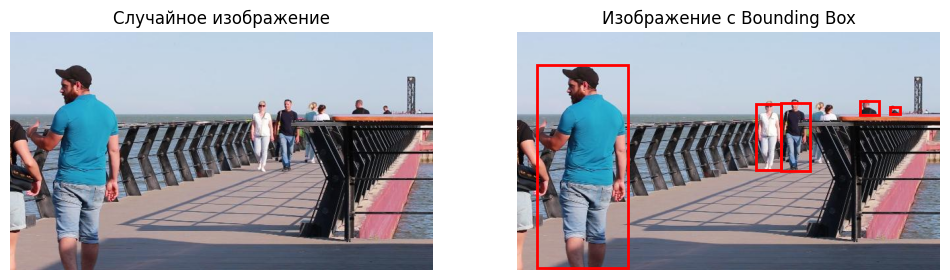

In [ ]:
# @title Вывод случайного изображения из базы


# Выбор случайного изображения
random_image_filename = random.choice(os.listdir(os.path.join(DATASET_DIR,'train/images/')))
image_path = os.path.join(DATASET_DIR, 'train/images/', random_image_filename)

# Получение соответствующего файла с координатами
label_filename = os.path.splitext(random_image_filename)[0] + '.txt'
label_path = os.path.join(DATASET_DIR, 'train/labels/', label_filename)

# Отображение случайного изображения
image = Image.open(image_path)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Случайное изображение")
plt.axis('off')

# Отображение изображения с bounding box, если файл с координатами существует
if os.path.exists(label_path):
    with open(label_path, 'r') as label_file:
        lines = label_file.readlines()

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    for line in lines:
        values = line.strip().split()[1:]
        if len(values) == 4:
            x, y, width, height = map(float, values)
            x *= image.width
            y *= image.height
            width *= image.width
            height *= image.height
            rect = plt.Rectangle((x - width / 2, y - height / 2), width, height,
                                 linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)


    plt.title("Изображение с Bounding Box")
    plt.axis('off')

else:
    print('Объектов на изображении нет')

plt.show()


# Формирование TerraYolo

In [ ]:
print(data_path)
print(DATASET_DIR)

/content/dataset/data.yaml
/content/dataset


In [ ]:
my_terra_yolov5 = TerraYoloV5(work_dir=DATASET_DIR)

In [ ]:
# Вывод структуры модели
my_terra_yolov5.get_annotation('yolov5m')

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.67 # model depth multiple
width_multiple: 0.75 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

# Обучение

In [ ]:
train_dict=dict()
train_dict['epochs'] = 100
train_dict['data'] = data_path
train_dict['batch'] = 4

In [ ]:
# в режиме 'train' запустим обучение с задаными параметрами
my_terra_yolov5.run(train_dict, exp_type='train')

command python /content/dataset/yolov5/train.py --epochs 100 --data /content/dataset/data.yaml --batch 4
2024-06-03 00:35:19.441004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 00:35:19.441055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 00:35:19.442871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=dataset/yolov5/yolov5s.pt, cfg=, data=/content/dataset/data.yaml, hyp=dataset/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evo

# Детекция

In [ ]:
# Сохраненные веса
!ls /content/dataset/yolov5/runs/train/exp/weights

best.pt  last.pt


In [ ]:
my_terra_yolov5.exp_dict['train']['last_exp_path']+'/weights/best.pt'

'/content/dataset/yolov5//runs/train//exp/weights/best.pt'

In [ ]:
TRAIN_DIR = '/content/dataset'

test_dict = dict()
test_dict['source'] = TRAIN_DIR+'/valid/images/'
test_dict['conf'] = 0.55                                     # порог вероятности обнаружения объекта
test_dict['weights'] = my_terra_yolov5.exp_dict['train']['last_exp_path']+'/weights/best.pt' #путь к весам модели

my_terra_yolov5.run(test_dict, exp_type='test')

command python /content/dataset/yolov5/detect.py --source /content/dataset/valid/images/ --conf 0.5 --weights /content/dataset/yolov5//runs/train//exp/weights/best.pt
detect: weights=['/content/dataset/yolov5//runs/train//exp/weights/best.pt'], source=/content/dataset/valid/images/, data=dataset/yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=dataset/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-318-gc0380fd8 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers...
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/100 /content/dataset/valid/images/104_jpg.rf.b77b947f6edac8b6974b5a3557b7c6f6.jpg: 384x64

img_path /content/dataset/yolov5//runs/detect//exp


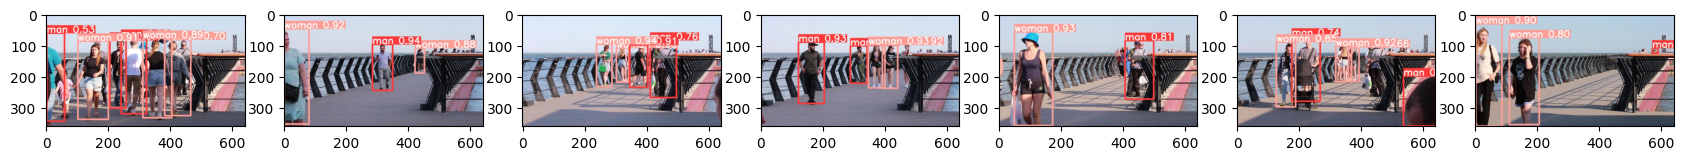

In [ ]:
my_terra_yolov5.show_test_images(n_samples=7, img_dir=None) #показать n_samples изображений

# ДООБУЧЕНИЕ

In [ ]:
train_dict['weights'] = my_terra_yolov5.exp_dict['train'][
                                            'last_exp_path']+'/weights/last.pt' #веса последней эпохи
train_dict['epochs'] = 30
my_terra_yolov5.run(train_dict, exp_type='train') #запуск скрипта train  с параметрами train_dict

command python /content/dataset/yolov5/train.py --epochs 30 --data /content/dataset/data.yaml --batch 4 --weights /content/dataset/yolov5//runs/train//exp/weights/last.pt
2024-06-03 02:38:12.992469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 02:38:12.992509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 02:38:12.994218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=/content/dataset/yolov5//runs/train//exp/weights/last.pt, cfg=, data=/content/dataset/data.yaml, hyp=dataset/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=4, imgsz=

In [ ]:
val_dict=dict()
val_dict['data'] = train_dict['data']

val_dict['weights'] = os.path.abspath(
        my_terra_yolov5.exp_dict['train']['last_exp_path']+'/weights/best.pt')
my_terra_yolov5.run(val_dict, exp_type='val')

command python /content/dataset/yolov5/val.py --data /content/dataset/data.yaml --weights /content/dataset/yolov5/runs/train/exp2/weights/best.pt
val: data=/content/dataset/data.yaml, weights=['/content/dataset/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=dataset/yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-318-gc0380fd8 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers...
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/dataset/valid/labels.cache... 100 images, 1 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

img_path /content/dataset/yolov5//runs/val//exp2


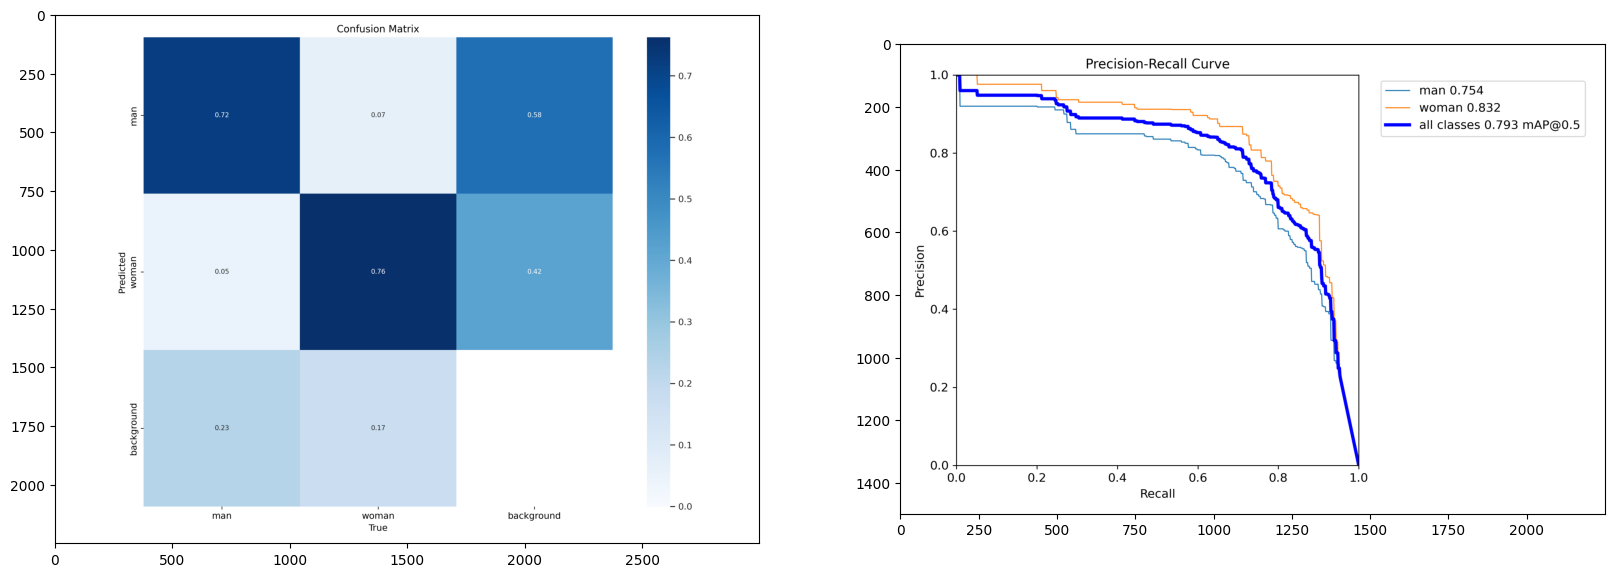

In [ ]:
my_terra_yolov5.show_val_results(img_path=None, img_list=['confusion_matrix.png', 'PR_curve.png'])

img_path /content/dataset/yolov5//runs/detect//exp


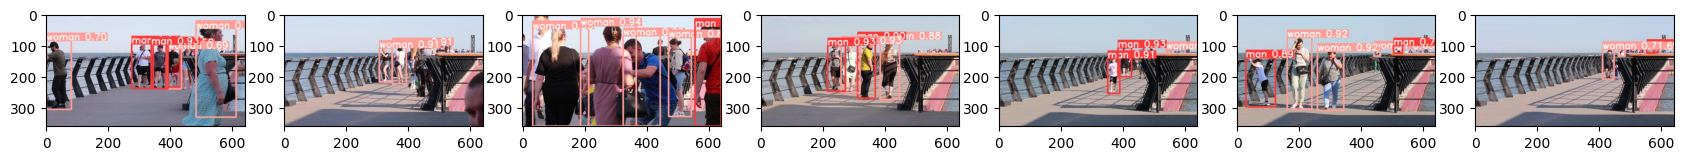

In [ ]:
my_terra_yolov5.show_test_images(n_samples=7, img_dir=None) #показать n_samples изображений

# Сохранение модели

In [ ]:
from google.colab import drive # импорт модуля для работы с диском
drive.mount('/content/drive/') # монтируем свой диск в папку drive рабочего каталога

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
my_drv_path = '/content/drive/MyDrive/' #сохраним путь к нашему диску в переменную

In [ ]:
!mkdir {my_drv_path}/yolo_weights/

In [ ]:
# сохраним путь в переменную
best_weights_path = my_terra_yolov5.exp_dict['train']['last_exp_path']+'/weights/best.pt'
# и скопируем веса
!cp {best_weights_path} {my_drv_path+'/yolo_weights/'}

In [ ]:
!ls {my_drv_path+'/yolo_weights/'}

best.pt


In [ ]:
!zip -r archive.zip /content/dataset/yolov5/runs/detect/exp

  adding: content/dataset/yolov5/runs/detect/exp/ (stored 0%)
  adding: content/dataset/yolov5/runs/detect/exp/352_jpg.rf.048052ec88e814135c501ad40343d781.jpg (deflated 4%)
  adding: content/dataset/yolov5/runs/detect/exp/307_jpg.rf.0e04c11b9e1d0427537cf2be205ad13d.jpg (deflated 6%)
  adding: content/dataset/yolov5/runs/detect/exp/136_jpg.rf.5f12a694df5f65692173ff555bb6c0d5.jpg (deflated 5%)
  adding: content/dataset/yolov5/runs/detect/exp/567_jpg.rf.546193d3ef7e3e806b61a45a59cc389d.jpg (deflated 6%)
  adding: content/dataset/yolov5/runs/detect/exp/489_jpg.rf.f9dc14a58af9d37e8fc81e2858bbb931.jpg (deflated 5%)
  adding: content/dataset/yolov5/runs/detect/exp/225_jpg.rf.e96e6ef87eb84a7303a9c4f6985fbe32.jpg (deflated 4%)
  adding: content/dataset/yolov5/runs/detect/exp/284_jpg.rf.8fbc6464040198c324889d8a71c78cf9.jpg (deflated 5%)
  adding: content/dataset/yolov5/runs/detect/exp/99_jpg.rf.96df0c04a217c517f9f6e4b875a5ca73.jpg (deflated 4%)
  adding: content/dataset/yolov5/runs/detect/exp/46

In [ ]:
!zip -r archive.zip /content/dataset/yolov5/runs/val/exp2

  adding: content/dataset/yolov5/runs/val/exp2/ (stored 0%)
  adding: content/dataset/yolov5/runs/val/exp2/val_batch1_labels.jpg (deflated 8%)
  adding: content/dataset/yolov5/runs/val/exp2/confusion_matrix.png (deflated 33%)
  adding: content/dataset/yolov5/runs/val/exp2/val_batch0_pred.jpg (deflated 7%)
  adding: content/dataset/yolov5/runs/val/exp2/val_batch0_labels.jpg (deflated 7%)
  adding: content/dataset/yolov5/runs/val/exp2/F1_curve.png (deflated 14%)
  adding: content/dataset/yolov5/runs/val/exp2/val_batch1_pred.jpg (deflated 7%)
  adding: content/dataset/yolov5/runs/val/exp2/P_curve.png (deflated 13%)
  adding: content/dataset/yolov5/runs/val/exp2/val_batch2_pred.jpg (deflated 7%)
  adding: content/dataset/yolov5/runs/val/exp2/PR_curve.png (deflated 15%)
  adding: content/dataset/yolov5/runs/val/exp2/val_batch2_labels.jpg (deflated 7%)
  adding: content/dataset/yolov5/runs/val/exp2/R_curve.png (deflated 13%)
